<a href="https://colab.research.google.com/github/Sheepybloke2-0/CSE841-Project/blob/main/gan_art1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN for Creating Color Images from a WikiArt Dataset


In [1]:
# Check that imports for the rest of the file work.
import tensorflow as tf

!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q kaggle

import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds

from IPython import display

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
from google.colab import files
import pathlib
kaggleJson = pathlib.Path("/content/.kaggle/kaggle.json")
if not kaggleJson.is_file():
  # files.upload()
  !mkdir -p /content/.kaggle/
  %cd /content/gdrive/My\ Drive/
  !cp ./kaggle.json /content/.kaggle/
  !chmod 600 /content/.kaggle/kaggle.json
%env KAGGLE_CONFIG_DIR=/content/.kaggle
!echo $KAGGLE_CONFIG_DIR
!kaggle config view
!kaggle datasets list

/content/gdrive/My Drive
env: KAGGLE_CONFIG_DIR=/content/.kaggle
/content/.kaggle
Configuration values from /content/.kaggle
- username: reubenlewis
- path: None
- proxy: None
- competition: None
ref                                                     title                                         size  lastUpdated          downloadCount  
------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
unanimad/us-election-2020                               US Election 2020                             429KB  2020-11-13 12:45:46           3382  
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                      353MB  2020-11-09 18:51:59           2037  
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University     2MB  2020-11-13 06:04:14            950  
headsortails/us-election-2020-presidential-debates      US Election 2020 - Pres

In [13]:
# %cd /content/gdrive/My\ Drive 
# !kaggle datasets download -d ipythonx/wikiart-gangogh-creating-art-gan
!rm -r /content/trainSet/
!rm -r /content/testSet/
artLib = pathlib.Path('/content/gdrive/My Drive/artgenreset.zip')
if not artLib.is_file():
  !kaggle datasets download -d parkerzmartin/artgenreset
  !ls
  !unzip artgenreset.zip
else:
  %cd /content/gdrive/My\ Drive/
  !unzip -u artgenreset.zip -d /content/ 
# !unzip wikiart-gangogh-creating-art-gan.zip
# dataDir = tf.keras.utils.get_file(origin=datasetURL, fname='wikiArt', extract=True)

Streaming output truncated to the last 5000 lines.
  inflating: /content/trainSet/Realism/38318.jpg  
  inflating: /content/trainSet/Realism/38368.jpg  
  inflating: /content/trainSet/Realism/38391.jpg  
  inflating: /content/trainSet/Realism/384.jpg  
  inflating: /content/trainSet/Realism/38400.jpg  
  inflating: /content/trainSet/Realism/38414.jpg  
  inflating: /content/trainSet/Realism/38425.jpg  
  inflating: /content/trainSet/Realism/3844.jpg  
  inflating: /content/trainSet/Realism/38448.jpg  
  inflating: /content/trainSet/Realism/38465.jpg  
  inflating: /content/trainSet/Realism/38473.jpg  
  inflating: /content/trainSet/Realism/38514.jpg  
  inflating: /content/trainSet/Realism/38523.jpg  
  inflating: /content/trainSet/Realism/38540.jpg  
  inflating: /content/trainSet/Realism/38590.jpg  
  inflating: /content/trainSet/Realism/38600.jpg  
  inflating: /content/trainSet/Realism/38607.jpg  
  inflating: /content/trainSet/Realism/38631.jpg  
  inflating: /content/trainSet/Rea

In [ ]:
# from cv2 import imread
# from os import listdir

# #for filename in listdir('C:/tensorflow/models/research/object_detection/images/train'):
# for dir in listdir('/content/trainSet'):
#   path = os.path.join('/content/trainSet/', dir)
#   for filename in listdir(path):
#     if filename.endswith(".jpg"):
#       print(path+filename)
#       imread(path+filename)


In [14]:
rootDir = pathlib.Path('/content/')
imageCount = len(list(rootDir.glob('trainSet/*/*.jpg')))
# imageCount = len(list(rootDir.glob('WikiArt/*/*')))
# imageCount = len(list(rootDir.glob('WikiArt/*/*.jpg')))
png = len(list(rootDir.glob('trainSet/*/*.png')))
py = len(list(rootDir.glob('trainSet/*/*.py')))

print(imageCount)
print(png)
print(py)

13421
0
0


In [15]:
# Parameters
# Total number of images
BUFFER_SIZE = imageCount
# Size of images to take and train with
BATCH_SIZE = 256
# BATCH_SIZE = 1024
# Number of cycles
EPOCHS = 50
im_size = (64, 64)
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
# Loads the data in from the real training set
trainPath = os.path.join(rootDir, 'trainSet')
testPath = os.path.join(rootDir, 'testSet')
trainDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    trainPath,
    validation_split=0.2, # Start with 80/20 split for validation
    subset="training",
    seed=123,
    image_size=im_size,
    batch_size=BATCH_SIZE
)

testDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    testPath,
    validation_split=0.2, # Start with 80/20 split for validation
    subset="validation",
    seed=123,
    image_size=im_size,
    batch_size=BATCH_SIZE
)

classNames = trainDataSet.class_names
print(classNames)

# Double check that our data is in the correct shape
print(trainDataSet.element_spec)
# trainDataSet = trainDataSet.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
trainDataSet.shuffle(buffer_size=BUFFER_SIZE)
trainDataSet = trainDataSet.apply(tf.data.experimental.ignore_errors())

Found 13421 files belonging to 3 classes.
Using 10737 files for training.
Found 2112 files belonging to 3 classes.
Using 422 files for validation.
['Impressionism', 'Realism', 'Romanticism']
(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


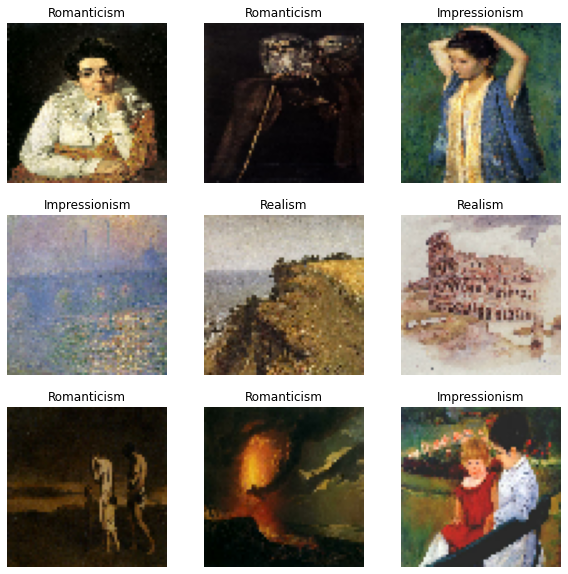

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in trainDataSet.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])
    plt.axis("off")

In [17]:
# Create a layer to scale the images to around [-1, 1]
normLayer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

normTrainDS = trainDataSet.map(lambda x, y: (normLayer(x), y))
normTrainDS.shuffle(BUFFER_SIZE)

print(normTrainDS.element_spec)

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [18]:
def make_generator_model():
    # Using the structure defined here: https://towardsdatascience.com/developing-a-dcgan-model-in-tensorflow-2-0-396bc1a101b2
    # Will upscale for 128x128
    model = tf.keras.Sequential()

    # Create our densely connected layer from the random input data
    model.add(layers.Dense(4*4*1028, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1028)))
    assert model.output_shape == (None, 4, 4, 1028) # Note: None is the batch size

    # Upsample and use our model to create an image based on inputs
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16448)             1644800   
_________________________________________________________________
batch_normalization (BatchNo (None, 16448)             65792     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16448)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1028)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         13158400  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0

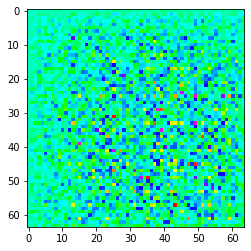

In [19]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gist_rainbow")
generator.summary()

In [21]:
def make_discriminator_model():
    # TODO: maybe have something like 7x7 for kernel size since we're trying to
    # do a larger image, or start with a larger size and shrink the kernels later
    # https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
    model = tf.keras.Sequential()
    normLayer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
    model.add(normLayer)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [22]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.04992879]], shape=(1, 1), dtype=float32)


In [23]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [27]:
%cd /content/gdrive/My\ Drive/

/content/gdrive/My Drive


In [28]:
checkpoint_dir = './'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [29]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      print("Generating Image")
      generated_images = generator(noise, training=True)
      print("Checking Image")
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      print("Checking Loss")
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
  
    print("Checking and applying gradients")
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [30]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    dataset.shuffle(BATCH_SIZE)

    for image_batch, labels_batch in dataset:
      print("next image batch")
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [31]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


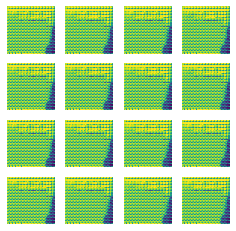

In [32]:
# train(normTrainDS, EPOCHS)
train(trainDataSet, EPOCHS)

In [33]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


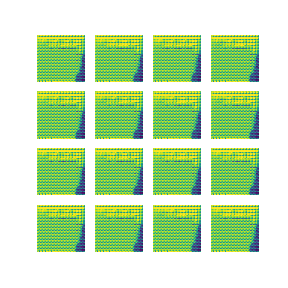

In [35]:
display_image(EPOCHS)


In [36]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)



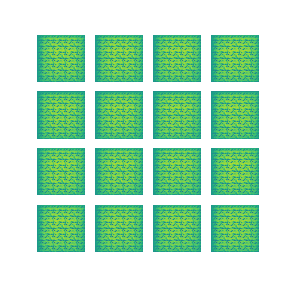

In [37]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
